# EDA: Bitcoin + Polymarket — Technical Appendix

This notebook is the **comprehensive EDA reference** supporting `EDA_Executive.ipynb`.

## Goals
1. Load, validate, and profile Coin Metrics (BTC on-chain) and Polymarket datasets
2. Perform rigorous data integrity and completeness checks
3. Explore temporal structure, distributions, and regime dynamics
4. Evaluate whether prediction-market signals show utility for BTC accumulation modeling

## Data Sources
| Source | File | Description |
|--------|------|-------------|
| Coin Metrics | `coinmetrics_btc.csv` | Daily on-chain + market metrics (~50 columns) |
| Polymarket | `finance_politics_markets.parquet` | Market metadata (questions, categories, volume) |
| Polymarket | `finance_politics_odds_history.parquet` | Time-series price/probability snapshots |
| Polymarket | `finance_politics_summary.parquet` | Per-market summary stats |
| Polymarket | `finance_politics_trades.parquet` | Granular trade data |
| Polymarket | `finance_politics_tokens.parquet` | Outcome token mappings |
| Polymarket | `finance_politics_event_stats.parquet` | Event-level aggregates |

---
## 0 · Setup & Configuration

In [10]:
from contextlib import contextmanager
from datetime import datetime
from pathlib import Path
from typing import Optional
import warnings, textwrap

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import polars as pl
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
plt.rcParams.update({'figure.dpi': 130, 'savefig.dpi': 150, 'figure.facecolor': 'white'})

# --- Path resolution ---
cwd = Path.cwd().resolve()
candidates = [cwd, cwd.parent, cwd.parent.parent]
PROJECT_ROOT = Path('/home/jovyan/work/bitcoin-analytics-capstone-template')
EDA_DIR      = PROJECT_ROOT / 'eda'
PLOTS_DIR    = EDA_DIR / 'plots'
DATA_DIR     = PROJECT_ROOT / 'data' 
COINMETRICS_PATH = DATA_DIR / 'Coin Metrics' / 'coinmetrics_btc.csv'
POLYMARKET_DIR   = DATA_DIR / 'Polymarket'
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"{COINMETRICS_PATH}")
print(f'PROJECT_ROOT : {PROJECT_ROOT}')
print(f'BTC CSV exists: {COINMETRICS_PATH.exists()}')
print(f'Poly dir exists: {POLYMARKET_DIR.exists()}')

/home/jovyan/work/bitcoin-analytics-capstone-template/data/Coin Metrics/coinmetrics_btc.csv
PROJECT_ROOT : /home/jovyan/work/bitcoin-analytics-capstone-template
BTC CSV exists: True
Poly dir exists: True


In [11]:
import sys
print(sys.executable)

/opt/conda/envs/practicum/bin/python


In [12]:
# --- Memory tracking utilities ---
def get_memory_usage_mb() -> float:
    try:
        import psutil
        return psutil.Process().memory_info().rss / 1024 / 1024
    except Exception:
        return float('nan')

def format_memory(mb: float) -> str:
    if np.isnan(mb): return 'N/A'
    return f'{mb/1024:.2f} GB' if mb >= 1024 else f'{mb:.2f} MB'

@contextmanager
def track_memory(operation_name: str):
    before = get_memory_usage_mb()
    print(f'[Mem] Before {operation_name}: {format_memory(before)}')
    try:
        yield
    finally:
        after = get_memory_usage_mb()
        delta = after - before if not (np.isnan(after) or np.isnan(before)) else float('nan')
        print(f'[Mem] After  {operation_name}: {format_memory(after)} (Δ {format_memory(delta)})')

# --- Datetime helpers ---
def safe_to_datetime(expr: pl.Expr) -> pl.Expr:
    return expr.cast(pl.Utf8).str.to_datetime(strict=False)

def to_date_if_present(df: pl.DataFrame, candidates: list[str]) -> pl.DataFrame:
    existing = [c for c in candidates if c in df.columns]
    if not existing: return df
    return df.with_columns([safe_to_datetime(pl.col(c)).alias(c) for c in existing])

---
## 0.1 · Data Loading

In [13]:
def load_bitcoin_data(filepath: Path) -> Optional[pl.DataFrame]:
    if not filepath.exists():
        print(f'⚠ Bitcoin file not found: {filepath}'); return None
    with track_memory('loading Bitcoin data'):
        df = (pl.scan_csv(filepath, infer_schema_length=10000)
              .with_columns(safe_to_datetime(pl.col('time')).alias('time'))
              .collect())
    print(f'✓ Loaded BTC rows: {len(df):,}  cols: {len(df.columns)}')
    return df


def load_polymarket_data(datadir: Path) -> dict[str, pl.DataFrame]:
    """Load all available Polymarket parquet files with timestamp correction."""
    files = {
        'markets':     datadir / 'finance_politics_markets.parquet',
        'odds':        datadir / 'finance_politics_odds_history.parquet',
        'summary':     datadir / 'finance_politics_summary.parquet',
        'tokens':      datadir / 'finance_politics_tokens.parquet',
        'trades':      datadir / 'finance_politics_trades.parquet',
        'event_stats': datadir / 'finance_politics_event_stats.parquet',
    }
    out: dict[str, pl.DataFrame] = {}
    datetime_candidates = ['timestamp','time','ts','created_at','updated_at','end_date','closed_at',
                           'first_trade','last_trade','first_market_start','last_market_end']
    for name, path in files.items():
        if not path.exists():
            print(f'⚠ Missing Polymarket file ({name}): {path.name}'); continue
        with track_memory(f'loading Polymarket {name}'):
            df = pl.scan_parquet(path).collect()
        present = [c for c in datetime_candidates if c in df.columns]
        if present:
            df = to_date_if_present(df, present)
        out[name] = df
        print(f'✓ {name}: {len(df):,} rows × {len(df.columns)} cols')
    return out


btc_df    = load_bitcoin_data(COINMETRICS_PATH)
poly_data = load_polymarket_data(POLYMARKET_DIR)

print('\n── Loaded objects ──')
print(f'btc_df is None: {btc_df is None}')
print(f'Polymarket tables: {list(poly_data.keys())}')

[Mem] Before loading Bitcoin data: 256.43 MB
[Mem] After  loading Bitcoin data: 290.28 MB (Δ 33.86 MB)
✓ Loaded BTC rows: 6,221  cols: 32
[Mem] Before loading Polymarket markets: 290.28 MB
[Mem] After  loading Polymarket markets: 323.62 MB (Δ 33.34 MB)
✓ markets: 78,321 rows × 10 cols
[Mem] Before loading Polymarket odds: 327.37 MB
[Mem] After  loading Polymarket odds: 437.01 MB (Δ 109.64 MB)
✓ odds: 2,143,181 rows × 4 cols
[Mem] Before loading Polymarket summary: 538.01 MB
[Mem] After  loading Polymarket summary: 555.09 MB (Δ 17.09 MB)
✓ summary: 78,321 rows × 9 cols
[Mem] Before loading Polymarket tokens: 557.34 MB
[Mem] After  loading Polymarket tokens: 573.98 MB (Δ 16.64 MB)
✓ tokens: 156,636 rows × 3 cols
[Mem] Before loading Polymarket trades: 573.98 MB
[Mem] After  loading Polymarket trades: 7.10 GB (Δ 6.54 GB)
✓ trades: 27,013,724 rows × 9 cols
[Mem] Before loading Polymarket event_stats: 8.36 GB
[Mem] After  loading Polymarket event_stats: 8.36 GB (Δ -0.19 MB)
✓ event_stats: 4

In [14]:
if btc_df is not None:
    print('── BTC preview ──')
    display(btc_df.head(3))

for name, df in poly_data.items():
    print(f'\n── {name} preview ──')
    display(df.head(3))

── BTC preview ──


time,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,FlowInExUSD,FlowOutExNtv,FlowOutExUSD,HashRate,IssTotNtv,IssTotUSD,PriceBTC,PriceUSD,ROI1yr,ROI30d,ReferenceRate,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
datetime[μs],i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
2009-01-03 00:00:00,0,0,1614334883,1614334883,0,null,null,null,0.0,0.0,null,0.0,null,null,null,null,1,null,null,null,null,null,null,null,0.0,0.0,null,null,0,0,null
2009-01-04 00:00:00,0,0,1614334883,1614334883,0,null,null,null,0.0,0.0,null,0.0,null,null,null,null,1,null,null,null,null,null,null,null,0.0,0.0,null,null,0,0,null
2009-01-05 00:00:00,0,0,1614334883,1614334883,0,null,null,null,0.0,0.0,null,0.0,null,null,null,null,1,null,null,null,null,null,null,null,0.0,0.0,null,null,0,0,null



── markets preview ──


market_id,question,slug,event_slug,category,volume,active,closed,created_at,end_date
str,str,str,str,str,f64,bool,bool,datetime[μs],datetime[μs]
"""242851""","""Will Bongbong Marcos be electe…","""will-bongbong-marcos-be-electe…","""will-bongbong-marcos-be-electe…","""Global Politics""",21533.53,true,true,2022-04-05 20:37:30,2022-05-09 00:00:00
"""242873""","""Will Sarah Palin win Alaska's …","""will-sarah-palin-win-in-the-al…","""will-sarah-palin-win-in-the-al…","""US-current-affairs""",79783.23,true,true,2022-04-05 22:41:57,2022-08-16 00:00:00
"""242918""","""Will US student loan payments …","""will-us-student-loan-payments-…","""will-us-student-loan-payments-…","""US-current-affairs""",18946.72,true,true,2022-04-05 23:33:47,2022-11-08 00:00:00



── odds preview ──


market_id,token_id,timestamp,price
str,str,datetime[μs],f64
"""255140""","""474357953615233060686693901910…",1970-01-20 21:10:04.802,0.055
"""255140""","""474357953615233060686693901910…",1970-01-20 21:11:31.203,0.055
"""255140""","""474357953615233060686693901910…",1970-01-20 21:12:57.604,0.055



── summary preview ──


market_id,question,slug,volume,active,token_count,trade_count,first_trade,last_trade
str,str,str,f64,bool,i64,i64,datetime[μs],datetime[μs]
"""798778""","""Will the price of Bitcoin be b…","""will-the-price-of-bitcoin-be-b…",8756.369075,true,2,279,1970-01-21 10:20:54.947,1970-01-21 10:21:24.701
"""893560""","""Ethereum Up or Down - December…","""eth-updown-15m-1765258200""",0.0,true,2,1274,1970-01-21 10:20:53.977,1970-01-21 10:20:58.955
"""821729""","""Will the price of Solana be ab…","""solana-above-180-on-december-1…",171.504726,true,2,8,1970-01-21 10:16:20.055,1970-01-21 10:20:55.033



── tokens preview ──


market_id,token_id,outcome
str,str,str
"""240383""","""555875344331027638590324435858…","""Yes"""
"""240383""","""111837615529992437689409005124…","""No"""
"""240384""","""113459643164060403919504712048…","""Yes"""



── trades preview ──


trade_id,market_id,token_id,timestamp,price,size,side,maker_address,taker_address
str,str,str,datetime[μs],f64,f64,str,str,str
"""0x036e539d9361b15d9ebee9bbd1ae…","""570360""","""214897725164100385865567443423…",1970-01-21 09:52:39.845,0.977,281.054246,"""BUY""","""0x27d76669db4321111b08fcc7e1a5…","""0xc5d563a36ae78145c45a50134d48…"
"""0x8685bb4a3134f9f664ed7e619b8e…","""570360""","""214897725164100385865567443423…",1970-01-21 09:52:39.857,0.977,28.0,"""BUY""","""0x33dcee9b336230ed7460c98bec8f…","""0xc5d563a36ae78145c45a50134d48…"
"""0xab71cfe8f3cb18e629b873b65b84…","""570360""","""214897725164100385865567443423…",1970-01-21 09:52:39.871,0.977,182.0,"""BUY""","""0x87370aa54b8f70fa1c9637f367aa…","""0xc5d563a36ae78145c45a50134d48…"



── event_stats preview ──


event_slug,market_count,total_volume,first_market_start,last_market_end
str,i64,f64,datetime[μs],datetime[μs]
"""will-binancecom-become-insolve…",1,269.41,2023-01-24 21:09:31,2023-02-28 00:00:00
"""gme-market-cap-on-may-17""",7,112281.62,2024-05-13 17:51:35,2024-05-17 12:00:00
"""republican-vp-nominee""",25,9.2566e7,2024-01-18 19:14:19,2024-09-08 12:00:00


---
# 1 · General Dataset Overview

We systematically check every loaded table for:
- **Shape & schema** (column types, counts)
- **Missingness** (null rates, patterns)
- **Duplicates & monotonicity** (time-series integrity)
- **Descriptive statistics** (central tendency, dispersion, tails)
- **Distributions** (histograms + skewness/kurtosis for key columns)

In [15]:
def profile_dataframe(df: pl.DataFrame, name: str) -> None:
    """Comprehensive profiling: shape, types, nulls, duplicates."""
    print(f'\n{"═"*60}')
    print(f' {name.upper()}')
    print(f'{"═"*60}')
    print(f'Shape: {df.shape[0]:,} rows × {df.shape[1]} columns')
    
    # Schema
    schema_df = pl.DataFrame({'column': list(df.schema.keys()),
                              'dtype': [str(v) for v in df.schema.values()]})
    display(schema_df)
    
    # Nulls
    nulls = (df.null_count()
             .transpose(include_header=True, header_name='column', column_names=['null_count'])
             .with_columns((pl.col('null_count') / len(df) * 100).round(2).alias('null_pct')))
    high_null = nulls.filter(pl.col('null_pct') > 0).sort('null_pct', descending=True)
    if len(high_null) > 0:
        print(f'\nColumns with nulls ({len(high_null)}):')
        display(high_null.head(20))
    else:
        print('\n✓ No null values in any column.')
    
    # Exact-row duplicates
    n_dup = len(df) - len(df.unique())
    print(f'\nExact duplicate rows: {n_dup:,} ({n_dup/max(len(df),1)*100:.2f}%)')
    
    # Numeric describe
    numeric_cols = [c for c, dt in df.schema.items() if dt.is_numeric()]
    if numeric_cols:
        print(f'\nDescriptive statistics ({len(numeric_cols)} numeric columns):')
        display(df.select(numeric_cols).describe())


# Profile all datasets
if btc_df is not None:
    profile_dataframe(btc_df, 'Coin Metrics BTC')

for name, df in poly_data.items():
    profile_dataframe(df, f'Polymarket · {name}')


════════════════════════════════════════════════════════════
 COIN METRICS BTC
════════════════════════════════════════════════════════════
Shape: 6,221 rows × 32 columns


column,dtype
str,str
"""time""","""Datetime(time_unit='us', time_…"
"""AdrActCnt""","""Int64"""
"""AdrBalCnt""","""Int64"""
"""AssetCompletionTime""","""Int64"""
"""AssetEODCompletionTime""","""Int64"""
…,…
"""SplyExUSD""","""Float64"""
"""SplyExpFut10yr""","""Float64"""
"""TxCnt""","""Int64"""



Columns with nulls (31):


column,null_count,null_pct
str,u32,f64
"""ReferenceRate""",6214,99.89
"""ReferenceRateETH""",6214,99.89
"""ReferenceRateEUR""",6214,99.89
"""ReferenceRateUSD""",6214,99.89
"""CapMrktEstUSD""",3823,61.45
…,…,…
"""HashRate""",7,0.11
"""IssTotNtv""",7,0.11
"""SplyExpFut10yr""",7,0.11



Exact duplicate rows: 0 (0.00%)

Descriptive statistics (31 numeric columns):


statistic,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,FlowInExUSD,FlowOutExNtv,FlowOutExUSD,HashRate,IssTotNtv,IssTotUSD,PriceBTC,PriceUSD,ROI1yr,ROI30d,ReferenceRate,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",6220.0,6220.0,6220.0,6220.0,6220.0,5659.0,5659.0,2398.0,6220.0,6220.0,5659.0,6220.0,5659.0,6214.0,6214.0,5659.0,6220.0,5659.0,5294.0,5629.0,7.0,7.0,7.0,7.0,6220.0,6220.0,5659.0,6214.0,6220.0,6220.0,5659.0
"""null_count""",1.0,1.0,1.0,1.0,1.0,562.0,562.0,3823.0,1.0,1.0,562.0,1.0,562.0,7.0,7.0,562.0,1.0,562.0,927.0,592.0,6214.0,6214.0,6214.0,6214.0,1.0,1.0,562.0,7.0,1.0,1.0,562.0
"""mean""",500905.731672,2.0809e7,1.6364e9,1.6364e9,149.86881,1.989795,3.8264e11,8.6339e11,48.228897,25838.964889,5.0364e8,26577.134164,5.5848e8,1.5146e8,3214.600599,1.5181e7,1.0,19809.987841,559.643271,14.638035,91487.781788,29.161564,78563.321591,91487.781788,1.4197e7,947998.367002,4.0124e10,1.9795e7,208414.228457,497111.757717,5.1167e9
"""std""",379439.356736,1.9582e7,4.2202e7,4.2202e7,30.743195,2.493876,5.8737e11,6.3984e11,91.173237,24373.197547,8.1787e8,24692.317635,9.5674e8,2.6345e8,2877.849238,1.7091e7,0.0,29699.078673,1944.97263,55.521166,1711.761816,0.295175,1441.867173,1711.761816,5.7946e6,818157.220356,7.3427e10,1.0372e6,170293.817001,373305.629144,7.5850e9
"""min""",0.0,0.0,1.6143e9,1.6143e9,0.0,0.386829,177670.489754,9.0586e10,0.0,0.0,0.0,0.0,0.0,1.9884e-7,200.0,307.0,1.0,0.050541,-83.730494,-61.668266,90406.142411,28.686314,77790.505193,90406.142411,0.0,0.0,0.0,1.707025e7,0.0,0.0,0.0
"""25%""",60723.0,1.375686e6,1.6143e9,1.6143e9,137.0,1.294308,3.6730e9,3.5528e11,8.210102,9740.165728,8.8193e6,9846.321594,8.5762e6,62.554011,943.75,966516.945821,1.0,260.651331,6.94795,-8.918985,90717.206315,29.145653,78047.851052,90717.206315,1.1005e7,88120.169787,8.9778e7,1.916555e7,47182.0,104349.0,1.0577e7
"""50%""",596940.0,1.8307255e7,1.6143e9,1.6143e9,150.0,1.754254,9.7931e10,6.9935e11,19.542684,21448.642391,1.4120e8,22144.333047,1.4169e8,5.5673e6,1975.0,8.7016e6,1.0,5728.351702,108.712873,3.305785,91096.916155,29.300019,78130.277588,91096.916155,1.6440e7,814911.95839,7.5922e9,2.0192e7,224435.0,557988.0,1.3492e9
"""75%""",817505.0,3.8516093e7,1.6340e9,1.6340e9,162.0,2.256992,5.5492e11,1.2376e12,45.830123,34085.94221,6.5356e8,36447.492482,6.9312e8,1.6529e8,4325.0,2.5843e7,1.0,28844.613678,325.273267,21.554302,91208.956261,29.348301,78167.205866,91208.956261,1.8841e7,1.5339e6,4.2274e10,2.0626e7,312571.0,798101.0,8.1901e9
"""max""",1.366494e6,5.592428e7,1.7684e9,1.7684e9,692.0,146.038332,2.4879e12,2.4875e12,1495.748916,284367.709273,7.2940e9,296550.594117,8.1840e9,1.3055e9,34600.0,7.6710e7,1.0,124824.453667,27666.627786,774.863956,95304.498294,29.48528,81816.258857,95304.498294,1.9975e7,2.8056e6,3.3450e11,2.0826e7,928131.0,2.041653e6,7.4786e10



════════════════════════════════════════════════════════════
 POLYMARKET · MARKETS
════════════════════════════════════════════════════════════
Shape: 78,321 rows × 10 columns


column,dtype
str,str
"""market_id""","""String"""
"""question""","""String"""
"""slug""","""String"""
"""event_slug""","""String"""
"""category""","""String"""
"""volume""","""Float64"""
"""active""","""Boolean"""
"""closed""","""Boolean"""
"""created_at""","""Datetime(time_unit='us', time_…"



Columns with nulls (1):


column,null_count,null_pct
str,u32,f64
"""end_date""",535,0.68



Exact duplicate rows: 0 (0.00%)

Descriptive statistics (1 numeric columns):


statistic,volume
str,f64
"""count""",78321.0
"""null_count""",0.0
"""mean""",232421.711476
"""std""",7.3075e6
"""min""",0.0
"""25%""",1060.276401
"""50%""",10923.199032
"""75%""",46512.204704
"""max""",1.5315e9



════════════════════════════════════════════════════════════
 POLYMARKET · ODDS
════════════════════════════════════════════════════════════
Shape: 2,143,181 rows × 4 columns


column,dtype
str,str
"""market_id""","""String"""
"""token_id""","""String"""
"""timestamp""","""Datetime(time_unit='us', time_…"
"""price""","""Float64"""



✓ No null values in any column.

Exact duplicate rows: 0 (0.00%)

Descriptive statistics (1 numeric columns):


statistic,price
str,f64
"""count""",2.143181e6
"""null_count""",0.0
"""mean""",0.500006
"""std""",0.390996
"""min""",0.0005
"""25%""",0.0675
"""50%""",0.5
"""75%""",0.9325
"""max""",1.0



════════════════════════════════════════════════════════════
 POLYMARKET · SUMMARY
════════════════════════════════════════════════════════════
Shape: 78,321 rows × 9 columns


column,dtype
str,str
"""market_id""","""String"""
"""question""","""String"""
"""slug""","""String"""
"""volume""","""Float64"""
"""active""","""Boolean"""
"""token_count""","""Int64"""
"""trade_count""","""Int64"""
"""first_trade""","""Datetime(time_unit='us', time_…"
"""last_trade""","""Datetime(time_unit='us', time_…"



Columns with nulls (2):


column,null_count,null_pct
str,u32,f64
"""first_trade""",42152,53.82
"""last_trade""",42152,53.82



Exact duplicate rows: 0 (0.00%)

Descriptive statistics (3 numeric columns):


statistic,volume,token_count,trade_count
str,f64,f64,f64
"""count""",78321.0,78321.0,78321.0
"""null_count""",0.0,0.0,0.0
"""mean""",232421.711476,1.999923,344.910356
"""std""",7.3075e6,0.029896,2078.716742
"""min""",0.0,0.0,0.0
"""25%""",1060.276401,2.0,0.0
"""50%""",10923.199032,2.0,0.0
"""75%""",46512.204704,2.0,173.0
"""max""",1.5315e9,5.0,189986.0



════════════════════════════════════════════════════════════
 POLYMARKET · TOKENS
════════════════════════════════════════════════════════════
Shape: 156,636 rows × 3 columns


column,dtype
str,str
"""market_id""","""String"""
"""token_id""","""String"""
"""outcome""","""String"""



✓ No null values in any column.

Exact duplicate rows: 0 (0.00%)

════════════════════════════════════════════════════════════
 POLYMARKET · TRADES
════════════════════════════════════════════════════════════
Shape: 27,013,724 rows × 9 columns


column,dtype
str,str
"""trade_id""","""String"""
"""market_id""","""String"""
"""token_id""","""String"""
"""timestamp""","""Datetime(time_unit='us', time_…"
"""price""","""Float64"""
"""size""","""Float64"""
"""side""","""String"""
"""maker_address""","""String"""
"""taker_address""","""String"""



Columns with nulls (2):


column,null_count,null_pct
str,u32,f64
"""taker_address""",21827,0.08
"""maker_address""",13041,0.05



Exact duplicate rows: 0 (0.00%)

Descriptive statistics (2 numeric columns):


statistic,price,size
str,f64,f64
"""count""",2.7013724e7,2.7013724e7
"""null_count""",0.0,0.0
"""mean""",0.512592,222.046563
"""std""",0.318306,3955.335226
"""min""",0.001,0.0019
"""25%""",0.25,5.17
"""50%""",0.5,12.4
"""75%""",0.79,50.0
"""max""",0.999,8.0623e6



════════════════════════════════════════════════════════════
 POLYMARKET · EVENT_STATS
════════════════════════════════════════════════════════════
Shape: 44,033 rows × 5 columns


column,dtype
str,str
"""event_slug""","""String"""
"""market_count""","""Int64"""
"""total_volume""","""Float64"""
"""first_market_start""","""Datetime(time_unit='us', time_…"
"""last_market_end""","""Datetime(time_unit='us', time_…"



Columns with nulls (1):


column,null_count,null_pct
str,u32,f64
"""last_market_end""",147,0.33



Exact duplicate rows: 0 (0.00%)

Descriptive statistics (2 numeric columns):


statistic,market_count,total_volume
str,f64,f64
"""count""",44033.0,44033.0
"""null_count""",0.0,0.0
"""mean""",1.778689,413405.874334
"""std""",2.786778,1.8830e7
"""min""",1.0,0.0
"""25%""",1.0,3217.403669
"""50%""",1.0,17087.824062
"""75%""",1.0,57651.021299
"""max""",69.0,3.6863e9


### 1.1 · Time-Series Integrity

For time-indexed data, we verify:
- Date ranges (min/max)
- Whether timestamps are sorted (monotonicity)
- Missing calendar days (gaps)

In [16]:
def check_time_integrity(df: pl.DataFrame, label: str, time_col: str = 'time') -> None:
    """Check monotonicity, gaps, and range for a time column."""
    if time_col not in df.columns:
        print(f'{label}: column "{time_col}" not found'); return
    
    ts = df[time_col].drop_nulls().sort()
    print(f'\n── {label} · {time_col} ──')
    print(f'  Range : {ts.min()} → {ts.max()}')
    print(f'  Count : {len(ts):,}  Nulls: {df[time_col].null_count():,}')
    
    # Monotonicity
    is_sorted = ts.equals(ts.sort())
    print(f'  Sorted: {"✓ Yes" if is_sorted else "✗ No"}')
    
    # Daily gap analysis (only for date-level granularity)
    try:
        dates = ts.dt.date().unique().sort()
        if len(dates) > 1:
            date_range = pl.date_range(dates.min(), dates.max(), '1d', eager=True)
            n_expected = len(date_range)
            n_actual   = len(dates)
            n_gaps     = n_expected - n_actual
            print(f'  Calendar days expected: {n_expected:,}  actual: {n_actual:,}  gaps: {n_gaps:,}')
            if 0 < n_gaps <= 10:
                missing = date_range.filter(~date_range.is_in(dates))
                print(f'  Missing dates: {missing.to_list()}')
    except Exception as e:
        print(f'  (gap analysis skipped: {e})')


if btc_df is not None:
    check_time_integrity(btc_df, 'BTC', 'time')

# Check key Polymarket time columns
for tbl, tcol in [('odds','timestamp'), ('trades','timestamp'),
                   ('markets','created_at'), ('summary','first_trade')]:
    if tbl in poly_data and tcol in poly_data[tbl].columns:
        check_time_integrity(poly_data[tbl], f'Poly·{tbl}', tcol)


── BTC · time ──
  Range : 2009-01-03 00:00:00 → 2026-01-14 00:00:00
  Count : 6,221  Nulls: 0
  Sorted: ✓ Yes
  Calendar days expected: 6,221  actual: 6,221  gaps: 0

── Poly·odds · timestamp ──
  Range : 1970-01-20 09:08:38.412000 → 1970-01-21 10:59:34.930000
  Count : 2,143,181  Nulls: 0
  Sorted: ✓ Yes
  Calendar days expected: 2  actual: 2  gaps: 0

── Poly·trades · timestamp ──
  Range : 1970-01-21 04:26:53.119000 → 1970-01-21 10:59:54.799000
  Count : 27,013,724  Nulls: 0
  Sorted: ✓ Yes

── Poly·markets · created_at ──
  Range : 2020-10-02 16:10:01 → 2025-12-10 05:32:21
  Count : 78,321  Nulls: 0
  Sorted: ✓ Yes
  Calendar days expected: 1,896  actual: 1,073  gaps: 823

── Poly·summary · first_trade ──
  Range : 1970-01-21 04:26:53.119000 → 1970-01-21 10:59:52.521000
  Count : 36,169  Nulls: 42,152
  Sorted: ✓ Yes


### 1.2 · Distribution Analysis

Examine the shape of key numeric columns — skewness, kurtosis, and visual histograms.
Understanding tail behavior is critical for accumulation strategy design.

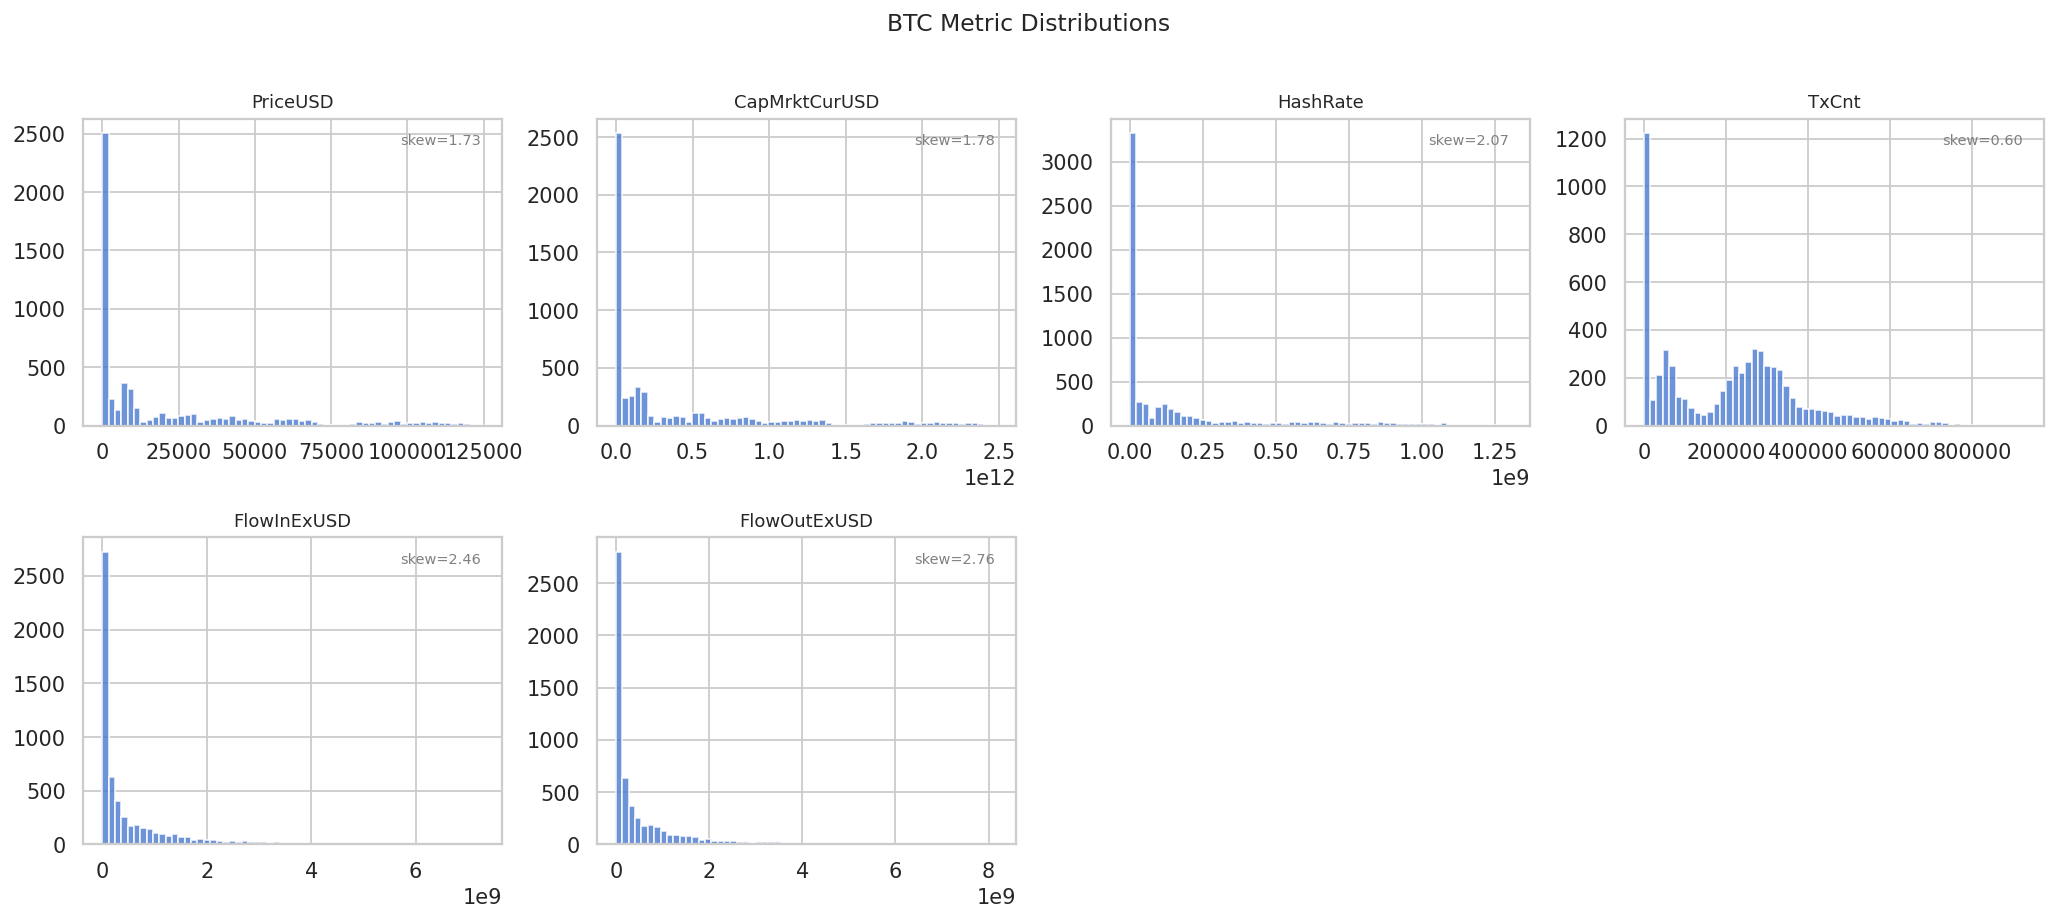

Saved: /home/jovyan/work/bitcoin-analytics-capstone-template/eda/plots/btc_distributions.png


In [17]:
if btc_df is not None:
    key_metrics = ['PriceUSD','CapMrktCurUSD','HashRate','TxCnt','FeeTotUSD',
                   'FlowInExUSD','FlowOutExUSD','VtyDayRet30d']
    available = [c for c in key_metrics if c in btc_df.columns]
    
    if available:
        n = len(available)
        ncols = min(4, n)
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
        axes = np.atleast_1d(axes).flatten()
        
        for i, col in enumerate(available):
            vals = btc_df[col].drop_nulls().to_numpy()
            ax = axes[i]
            ax.hist(vals, bins=60, edgecolor='white', alpha=0.8)
            ax.set_title(col, fontsize=10)
            skew = float(np.nanmean(((vals - np.nanmean(vals)) / np.nanstd(vals))**3)) if len(vals) > 3 else 0
            ax.text(0.95, 0.95, f'skew={skew:.2f}', transform=ax.transAxes,
                    ha='right', va='top', fontsize=8, color='gray')
        
        for j in range(i+1, len(axes)): axes[j].set_visible(False)
        fig.suptitle('BTC Metric Distributions', fontsize=13, y=1.01)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'btc_distributions.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f'Saved: {PLOTS_DIR / "btc_distributions.png"}')

---
# 2 · Bitcoin On-Chain Exploration

Deep dive into BTC price dynamics, volatility regimes, and on-chain fundamentals.
These features form the backbone of any accumulation model.

### 2.1 · Price History & Volatility Regimes

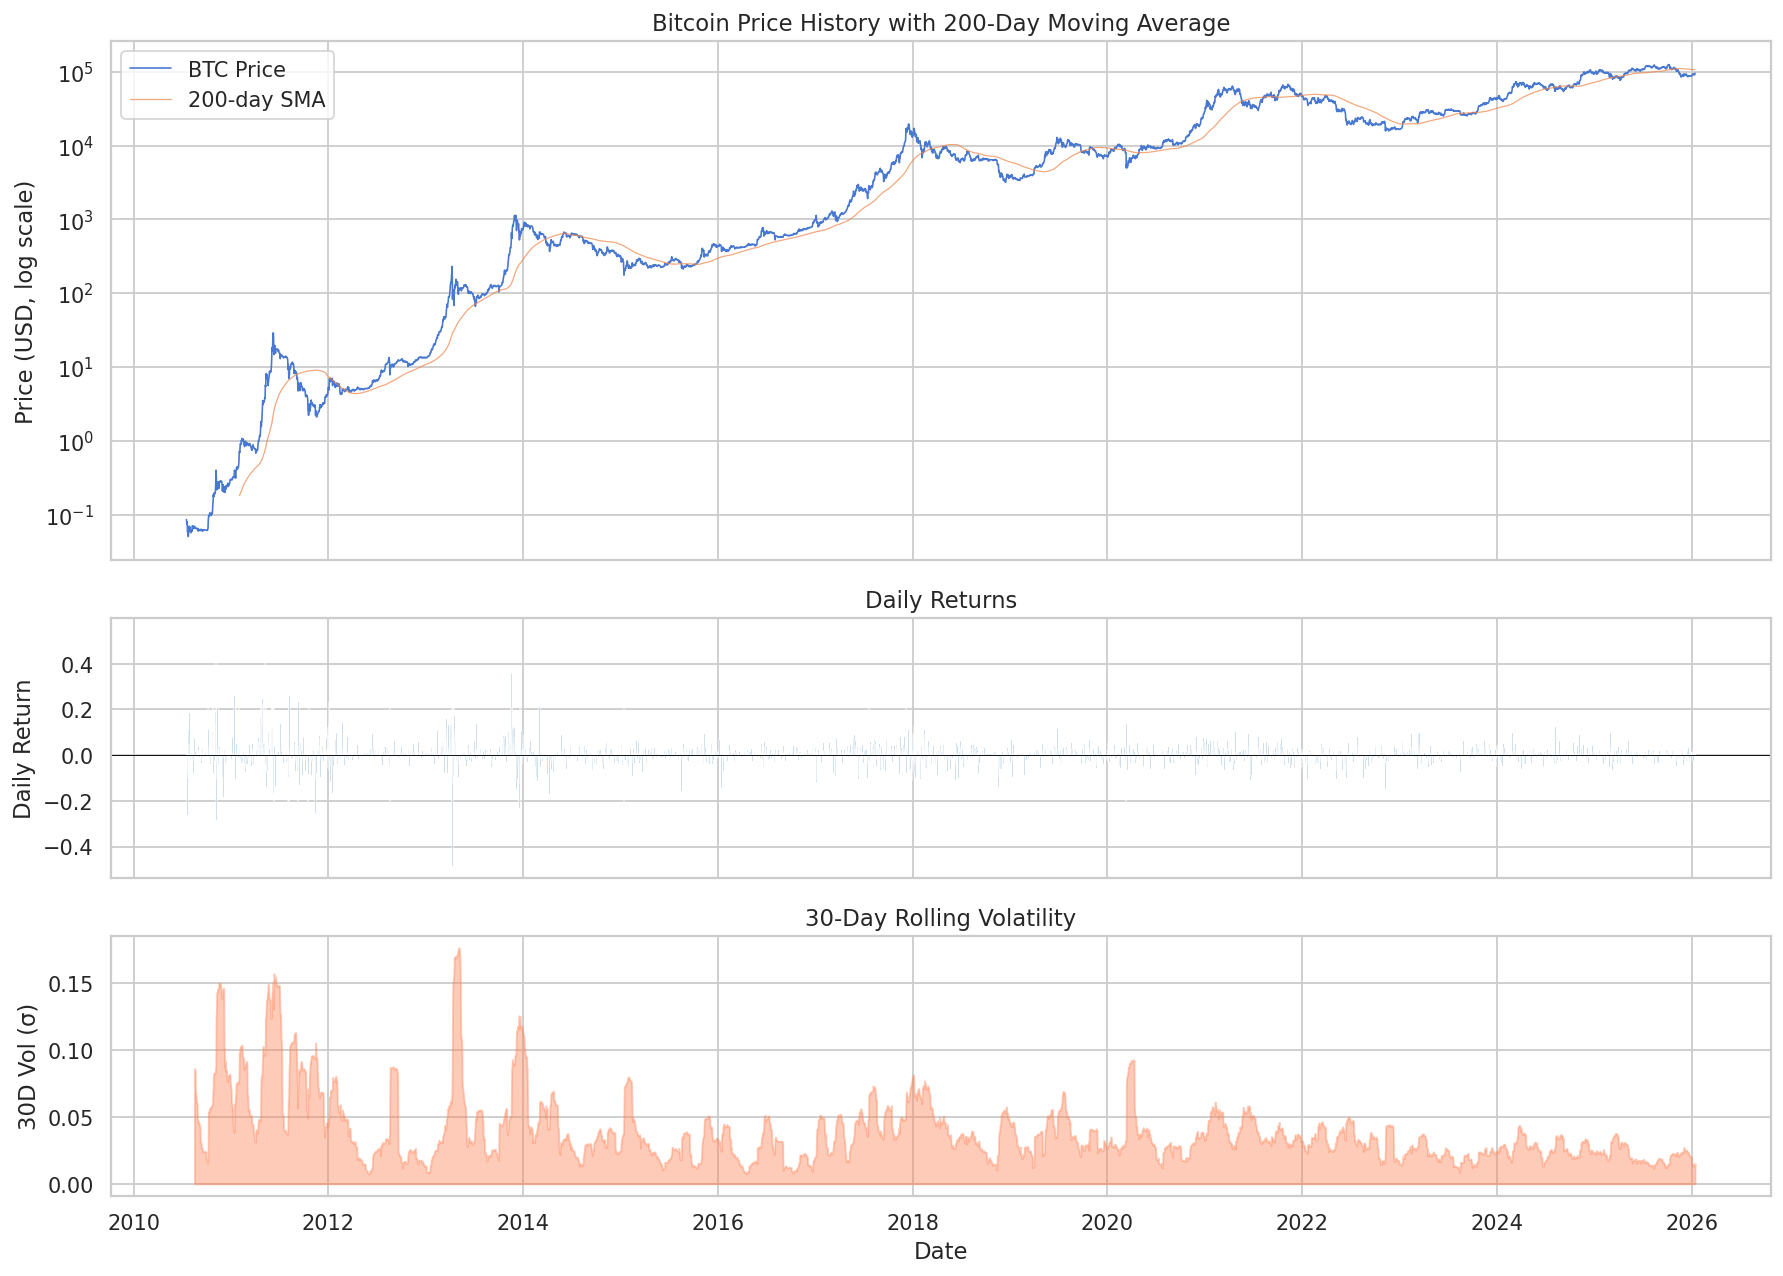

Saved: btc_price_vol_returns.png


In [18]:
if btc_df is not None and {'time','PriceUSD'}.issubset(set(btc_df.columns)):
    btc_ts = (btc_df.select('time','PriceUSD').drop_nulls().sort('time')
              .with_columns([
                  pl.col('PriceUSD').pct_change().alias('daily_ret'),
              ])
              .with_columns([
                  pl.col('daily_ret').rolling_std(window_size=30).alias('vol_30d'),
                  pl.col('daily_ret').rolling_mean(window_size=200).alias('ma200_ret'),
                  pl.col('PriceUSD').rolling_mean(window_size=200).alias('sma200'),
              ]))
    pdf = btc_ts.to_pandas()
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True,
                             gridspec_kw={'height_ratios': [3, 1.5, 1.5]})
    
    # Price + SMA200
    axes[0].semilogy(pdf['time'], pdf['PriceUSD'], label='BTC Price', linewidth=0.9)
    axes[0].semilogy(pdf['time'], pdf['sma200'], label='200-day SMA', linewidth=0.7, alpha=0.7)
    axes[0].set_ylabel('Price (USD, log scale)')
    axes[0].set_title('Bitcoin Price History with 200-Day Moving Average')
    axes[0].legend()
    
    # Daily returns
    axes[1].bar(pdf['time'], pdf['daily_ret'], width=1, alpha=0.5, color='steelblue')
    axes[1].set_ylabel('Daily Return')
    axes[1].set_title('Daily Returns')
    axes[1].axhline(0, color='black', linewidth=0.5)
    
    # 30d vol
    axes[2].fill_between(pdf['time'], 0, pdf['vol_30d'], alpha=0.4, color='coral')
    axes[2].set_ylabel('30D Vol (σ)')
    axes[2].set_title('30-Day Rolling Volatility')
    axes[2].set_xlabel('Date')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'btc_price_vol_returns.png', dpi=150)
    plt.show()
    print(f'Saved: btc_price_vol_returns.png')
else:
    print('BTC price plot skipped: data not loaded.')

### 2.2 · On-Chain Fundamentals (MVRV, NVT, Exchange Flows)

These metrics are widely used signals in crypto-native valuation:
- **MVRV** (Market Value / Realised Value): values > 3 historically indicate overheating
- **NVT** (Network Value to Transactions): high NVT suggests price outpacing utility
- **Exchange flows**: net outflows from exchanges often precede supply squeezes

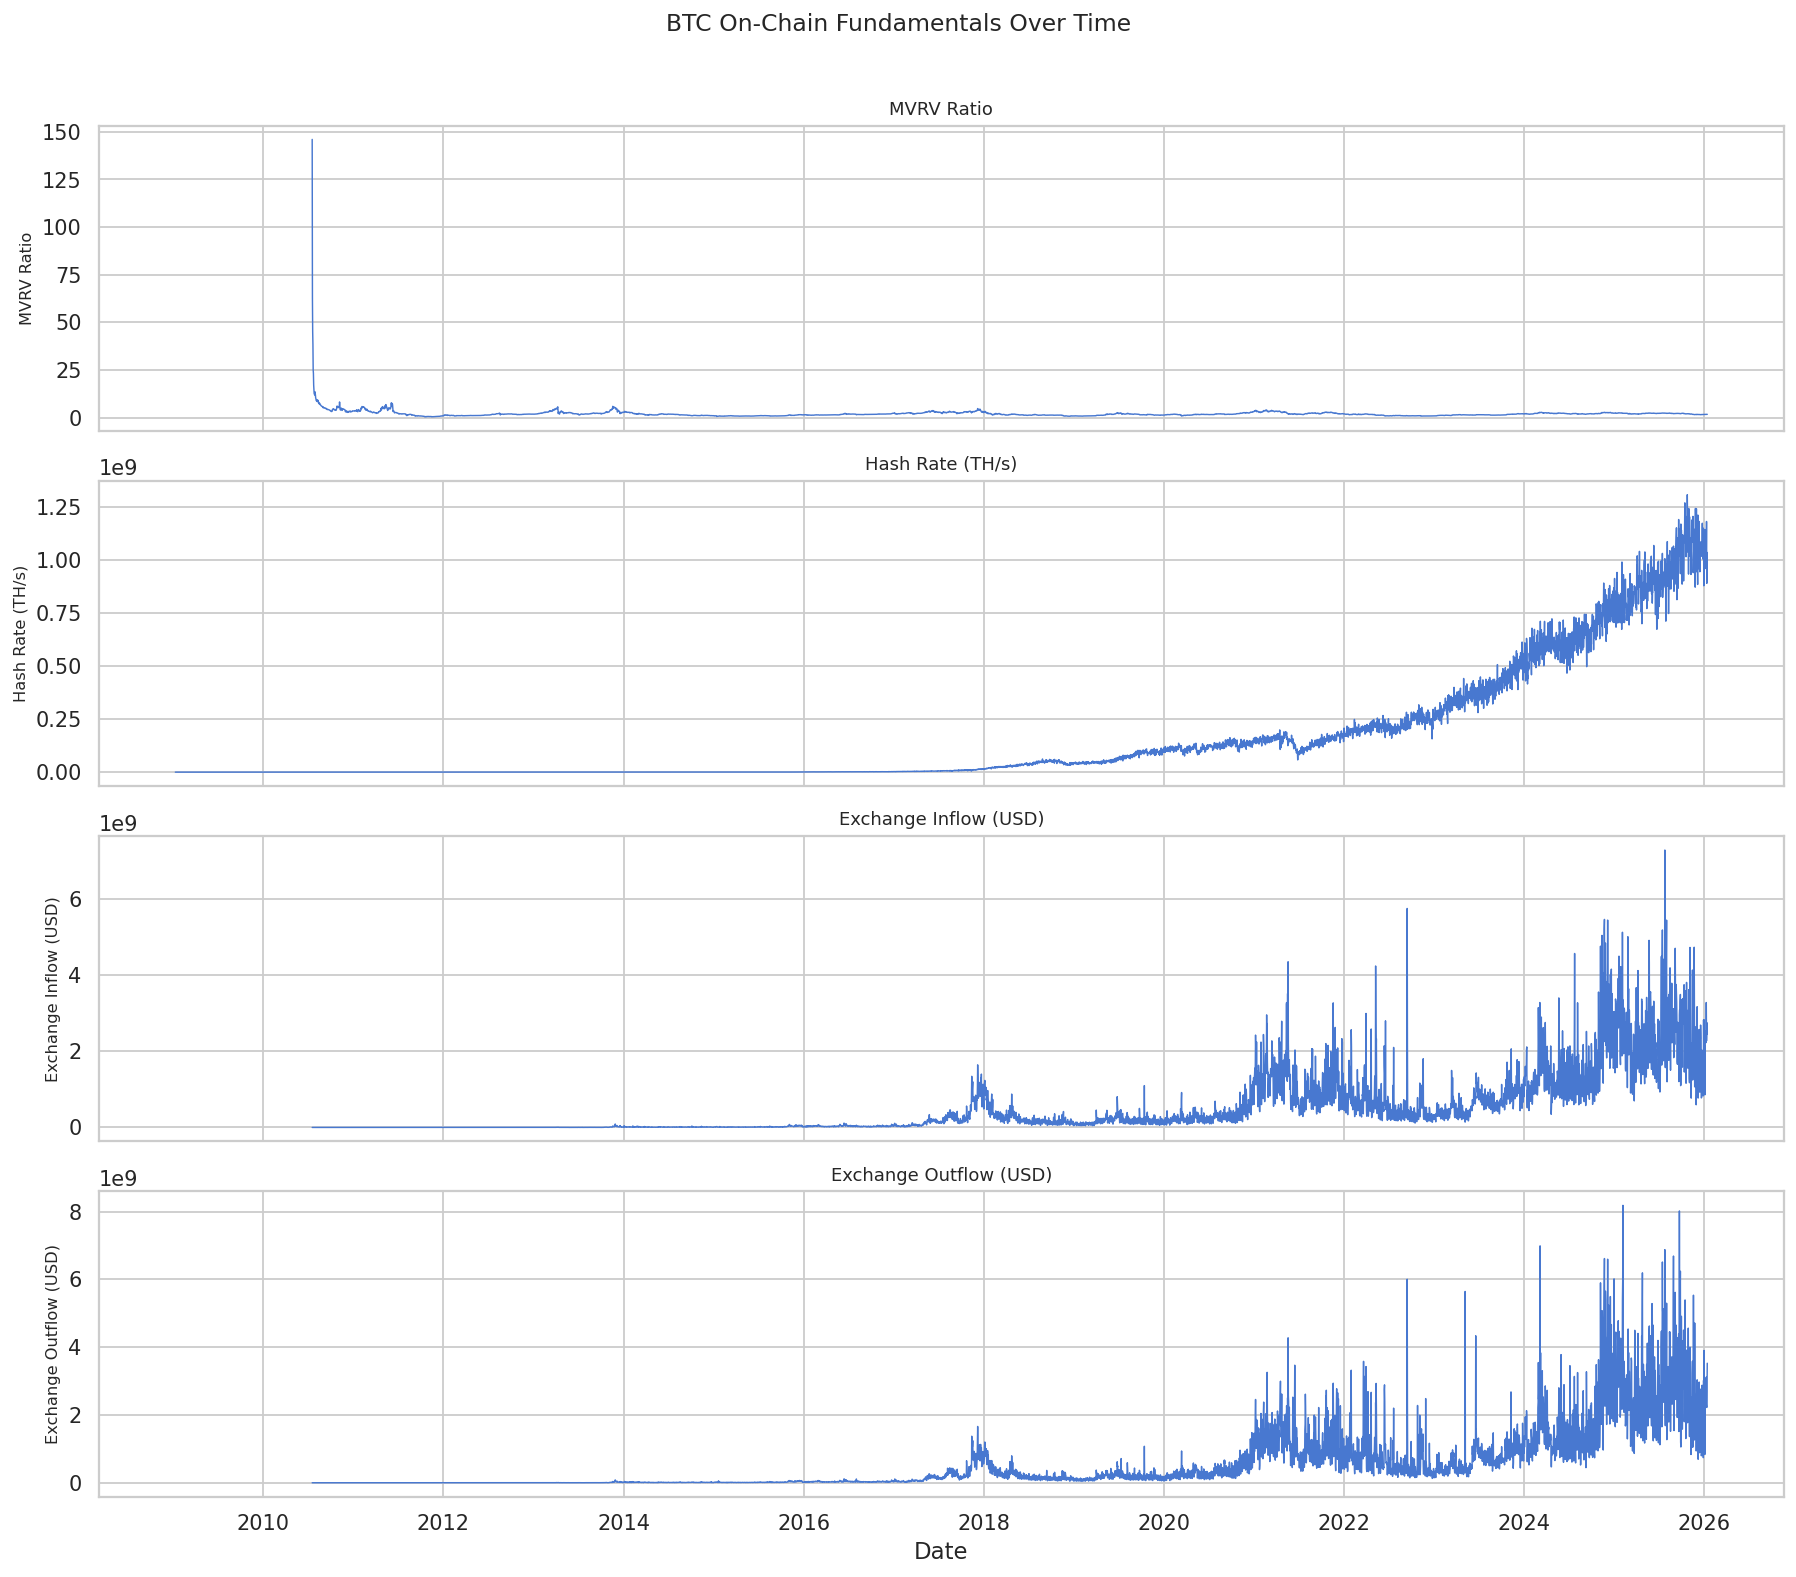

In [19]:
if btc_df is not None:
    onchain_cols = {
        'CapMVRVCur': 'MVRV Ratio',
        'NVTAdj': 'NVT (Adjusted)',
        'HashRate': 'Hash Rate (TH/s)',
        'FlowInExUSD': 'Exchange Inflow (USD)',
        'FlowOutExUSD': 'Exchange Outflow (USD)',
        'SplyActPct1yr': 'Active Supply % (1yr)',
    }
    avail = {k: v for k, v in onchain_cols.items() if k in btc_df.columns}
    
    if avail and 'time' in btc_df.columns:
        n = len(avail)
        fig, axes = plt.subplots(n, 1, figsize=(14, 3*n), sharex=True)
        if n == 1: axes = [axes]
        pdf = btc_df.select(['time'] + list(avail.keys())).drop_nulls(subset=['time']).sort('time').to_pandas()
        
        for ax, (col, label) in zip(axes, avail.items()):
            ax.plot(pdf['time'], pdf[col], linewidth=0.8)
            ax.set_ylabel(label, fontsize=9)
            ax.set_title(label, fontsize=10)
        
        axes[-1].set_xlabel('Date')
        fig.suptitle('BTC On-Chain Fundamentals Over Time', fontsize=13, y=1.01)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'btc_onchain_fundamentals.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print('On-chain metrics not available in loaded data.')

### 2.3 · Correlation Structure of BTC Metrics

Understanding co-movement helps identify redundant vs. complementary features for modeling.

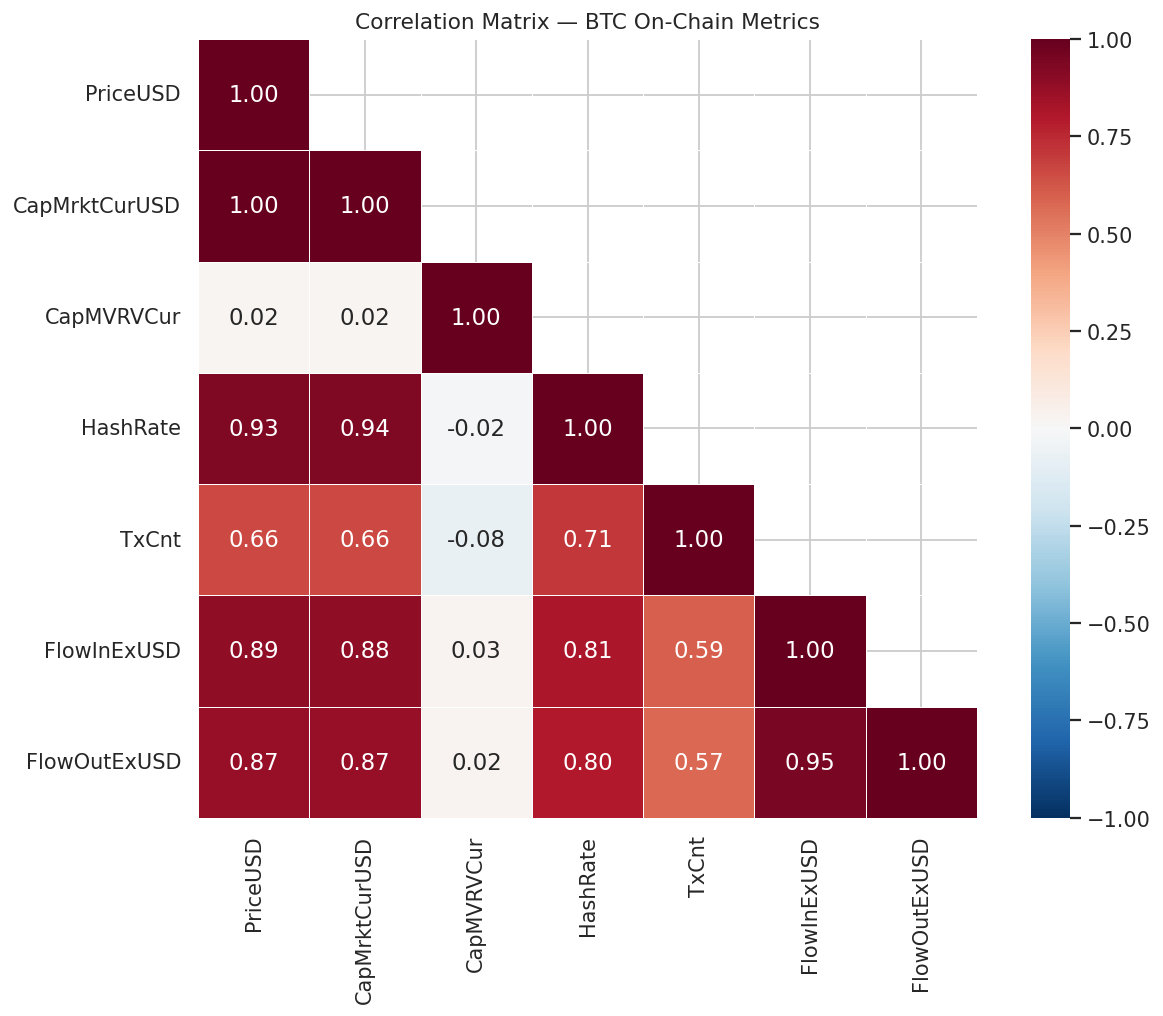

Key observations:
  • PriceUSD and CapMrktCurUSD are near-perfectly correlated (expected)
  • Look for low-correlation metrics as independent feature candidates


In [20]:
if btc_df is not None:
    corr_candidates = ['PriceUSD','CapMrktCurUSD','CapMVRVCur','CapRealUSD',
                       'HashRate','TxCnt','NVTAdj','FlowInExUSD','FlowOutExUSD',
                       'VtyDayRet30d','SplyActPct1yr','FeeTotUSD']
    corr_cols = [c for c in corr_candidates if c in btc_df.columns]
    
    if len(corr_cols) >= 3:
        corr_pd = btc_df.select(corr_cols).to_pandas()
        corr_matrix = corr_pd.corr()
        
        fig, ax = plt.subplots(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
                    cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                    square=True, linewidths=0.5, ax=ax)
        ax.set_title('Correlation Matrix — BTC On-Chain Metrics', fontsize=12)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'btc_correlation_matrix.png', dpi=150)
        plt.show()
        print('Key observations:')
        print('  • PriceUSD and CapMrktCurUSD are near-perfectly correlated (expected)')
        print('  • Look for low-correlation metrics as independent feature candidates')

---
# 3 · Polymarket Exploration

Understanding the structure, activity, and signal quality of prediction-market data before
attempting cross-feature analysis with BTC.

### 3.1 · Market Landscape

Total markets: 78,321
Active: 78,321  |  Closed: 0

Volume distribution:


statistic,value
str,f64
"""count""",78321.0
"""null_count""",0.0
"""mean""",232421.711476
"""std""",7.3075e6
"""min""",0.0
"""25%""",1060.276401
"""50%""",10923.199032
"""75%""",46512.204704
"""max""",1.5315e9



Category breakdown:


category,n_markets,total_vol,avg_vol
str,u32,f64,f64
"""""",77516,1.8032e10,232626.295069
"""US-current-affairs""",265,1.1855e8,447370.468665
"""Crypto""",340,4.1457e7,121932.274824
"""Business""",113,4.6173e6,40861.419558
"""Global Politics""",56,2.8685e6,51222.633036
…,…,…,…
"""Pop-Culture """,4,898159.7,224539.925
"""Tech""",2,269207.69,134603.845
"""Coronavirus""",3,136461.25,45487.083333


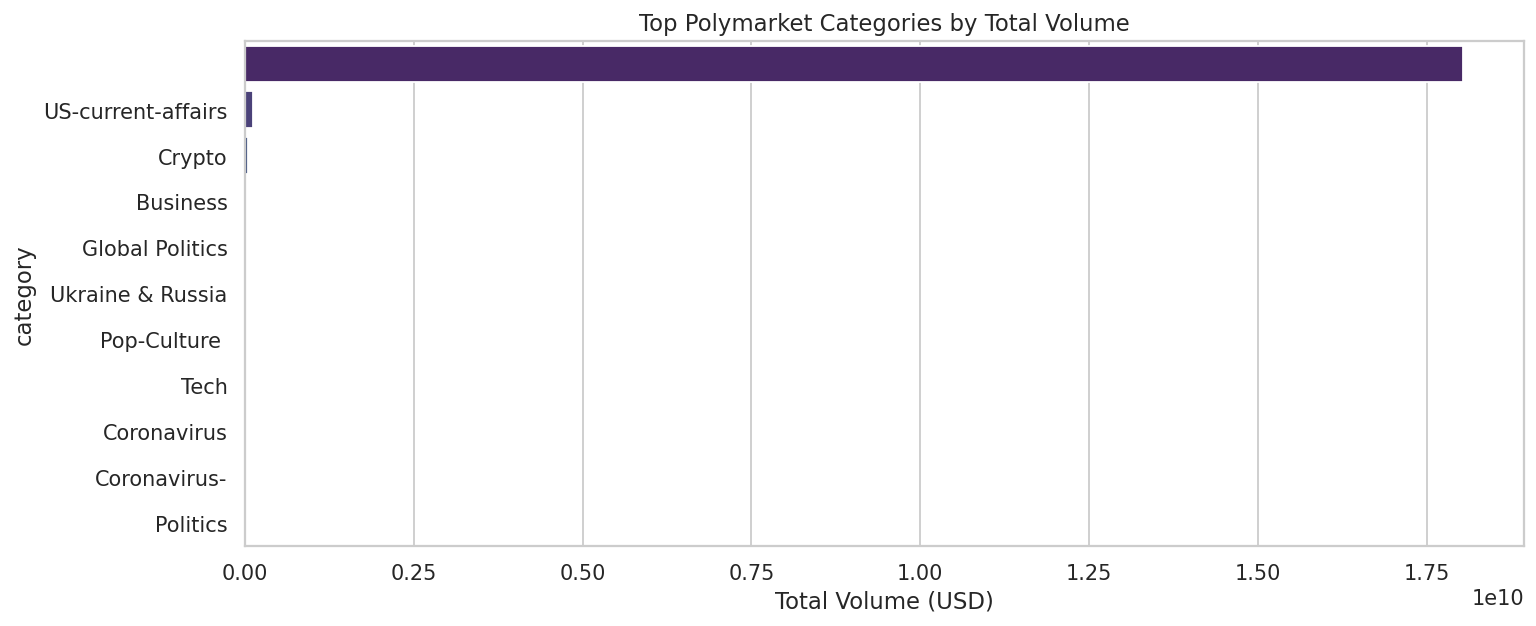

In [21]:
markets_df = poly_data.get('markets')
if markets_df is not None:
    print(f'Total markets: {len(markets_df):,}')
    
    if 'active' in markets_df.columns:
        active = markets_df['active'].sum()
        print(f'Active: {active:,}  |  Closed: {len(markets_df) - active:,}')
    
    if 'volume' in markets_df.columns:
        vol_stats = markets_df['volume'].describe()
        print(f'\nVolume distribution:')
        display(vol_stats)
    
    # Category breakdown
    cat_col = next((c for c in ['category','category_slug'] if c in markets_df.columns), None)
    vol_col = next((c for c in ['volume','total_volume'] if c in markets_df.columns), None)
    
    if cat_col and vol_col:
        cat_summary = (markets_df.group_by(cat_col)
                       .agg([pl.len().alias('n_markets'),
                             pl.col(vol_col).sum().alias('total_vol'),
                             pl.col(vol_col).mean().alias('avg_vol')])
                       .sort('total_vol', descending=True))
        print(f'\nCategory breakdown:')
        display(cat_summary)
        
        # Bar chart
        top = cat_summary.head(12).to_pandas()
        fig, ax = plt.subplots(figsize=(12, 5))
        sns.barplot(data=top, x='total_vol', y=cat_col, ax=ax, palette='viridis')
        ax.set_title('Top Polymarket Categories by Total Volume')
        ax.set_xlabel('Total Volume (USD)')
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'polymarket_categories.png', dpi=150)
        plt.show()

### 3.2 · Temporal Activity (Odds & Trades)

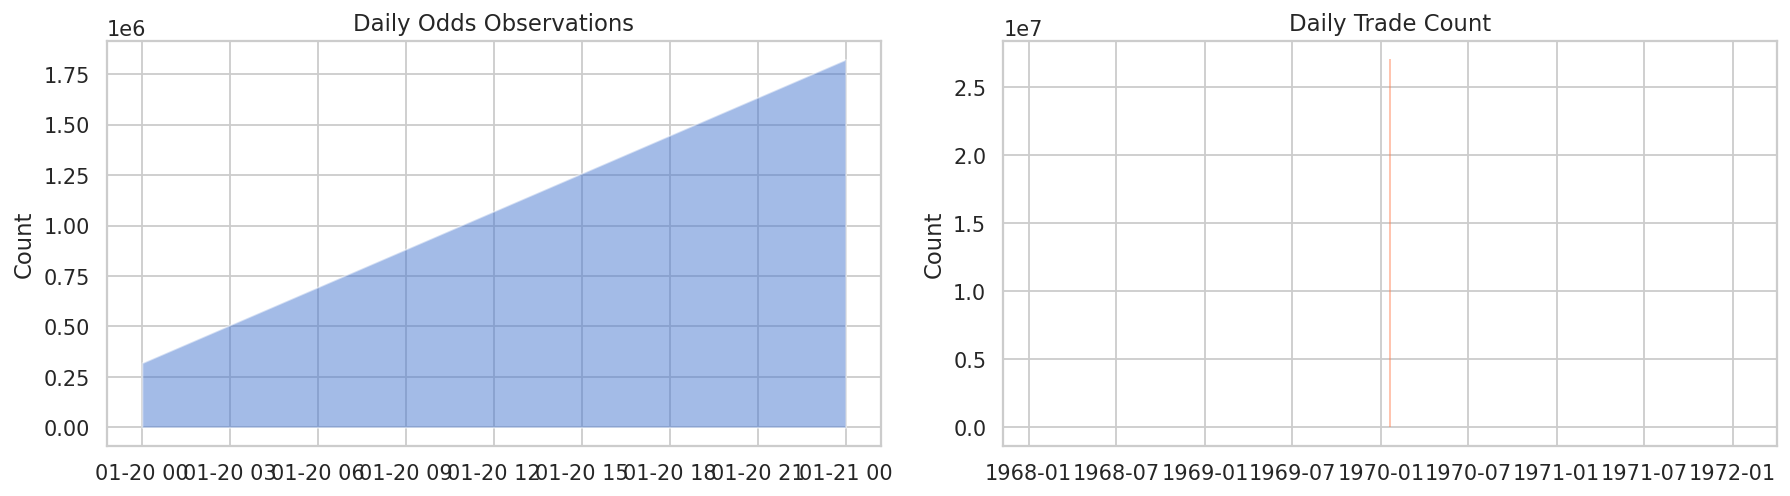

In [22]:
odds_df = poly_data.get('odds')
trades_df = poly_data.get('trades')

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Odds activity over time
ts_col = None
if odds_df is not None:
    ts_col = next((c for c in ['timestamp','time'] if c in odds_df.columns), None)
if odds_df is not None and ts_col:
    daily_odds = (odds_df.with_columns(pl.col(ts_col).dt.date().alias('date'))
                  .group_by('date').agg(pl.len().alias('n_obs'))
                  .sort('date').to_pandas())
    axes[0].fill_between(daily_odds['date'], 0, daily_odds['n_obs'], alpha=0.5)
    axes[0].set_title('Daily Odds Observations')
    axes[0].set_ylabel('Count')
else:
    axes[0].text(0.5, 0.5, 'Odds data not available', ha='center', va='center', transform=axes[0].transAxes)

# Trades activity over time
t_col = None
if trades_df is not None:
    t_col = next((c for c in ['timestamp','time'] if c in trades_df.columns), None)
if trades_df is not None and t_col:
    daily_trades = (trades_df.with_columns(pl.col(t_col).dt.date().alias('date'))
                    .group_by('date').agg(pl.len().alias('n_trades'))
                    .sort('date').to_pandas())
    axes[1].fill_between(daily_trades['date'], 0, daily_trades['n_trades'], alpha=0.5, color='coral')
    axes[1].set_title('Daily Trade Count')
    axes[1].set_ylabel('Count')
else:
    axes[1].text(0.5, 0.5, 'Trades data not available', ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'polymarket_temporal_activity.png', dpi=150)
plt.show()

---
# 4 · Prediction Market × BTC: Cross-Feature Analysis

**Required investigation** per the outline: evaluate Polymarket utility for BTC accumulation strategies.

We analyze:
1. Daily feature alignment (BTC returns vs. prediction-market activity)
2. Lead/lag correlations (do market signals lead BTC moves?)
3. Regime-conditioned analysis (do signals behave differently in high/low vol?)
4. Statistical significance tests

### 4.1 · Daily Feature Merge & Baseline Correlation

In [23]:
def first_present(cols, options):
    return next((c for c in options if c in cols), None)

merged = None  # will be set if merge succeeds

if btc_df is not None and poly_data.get('odds') is not None:
    odds = poly_data['odds']
    btc_time = first_present(btc_df.columns, ['time','date','timestamp'])
    odds_time = first_present(odds.columns, ['timestamp','time','created_at'])
    odds_prob = first_present(odds.columns, ['price','probability','yes_price','odds','mid'])
    
    if btc_time and odds_time and odds_prob and 'PriceUSD' in btc_df.columns:
        # BTC daily features
        btc_daily = (btc_df.with_columns(pl.col(btc_time).dt.date().alias('date'))
                     .group_by('date').agg([
                         pl.col('PriceUSD').last().alias('btc_close'),
                         pl.col('PriceUSD').pct_change().last().alias('btc_ret'),
                     ]).sort('date'))
        
        # Add vol if available
        if 'VtyDayRet30d' in btc_df.columns:
            btc_vol = (btc_df.with_columns(pl.col(btc_time).dt.date().alias('date'))
                       .group_by('date').agg(pl.col('VtyDayRet30d').last().alias('btc_vol30d'))
                       .sort('date'))
            btc_daily = btc_daily.join(btc_vol, on='date', how='left')
        
        # Polymarket daily features
        odds_daily = (odds.with_columns(pl.col(odds_time).dt.date().alias('date'))
                      .group_by('date').agg([
                          pl.len().alias('pm_obs_count'),
                          pl.col(odds_prob).mean().alias('pm_avg_prob'),
                          pl.col(odds_prob).std().alias('pm_prob_dispersion'),
                          pl.col('market_id').n_unique().alias('pm_active_markets') if 'market_id' in odds.columns else pl.lit(None).alias('pm_active_markets'),
                      ]).sort('date'))
        
        merged = btc_daily.join(odds_daily, on='date', how='inner').drop_nulls()
        print(f'Merged daily rows: {len(merged):,}')
        print(f'Date range: {merged["date"].min()} → {merged["date"].max()}')
        display(merged.head())
        
        # Correlation heatmap
        if len(merged) > 10:
            feat_cols = [c for c in merged.columns if c != 'date']
            corr_pd = merged.select(feat_cols).to_pandas()
            corr = corr_pd.corr()
            
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f',
                        center=0, square=True, ax=ax)
            ax.set_title('BTC Returns vs Polymarket Daily Features')
            plt.tight_layout()
            plt.savefig(PLOTS_DIR / 'btc_vs_polymarket_corr.png', dpi=150)
            plt.show()
    else:
        print(f'Cross-feature analysis skipped: missing columns.')
else:
    print('Cross-feature analysis skipped: BTC or odds table not loaded.')

Merged daily rows: 0
Date range: None → None


date,btc_close,btc_ret,pm_obs_count,pm_avg_prob,pm_prob_dispersion,pm_active_markets
date,f64,f64,u32,f64,f64,u32


### 4.2 · Lead/Lag Analysis

Do Polymarket features at time $t-k$ predict BTC returns at time $t$?
We test lags from 1 to 14 days.

In [24]:
if merged is not None and len(merged) > 30:
    pm_features = [c for c in merged.columns if c.startswith('pm_')]
    lags = list(range(1, 15))
    
    lag_corrs = {}
    merged_pd = merged.sort('date').to_pandas().set_index('date')
    
    for feat in pm_features:
        corrs = []
        for lag in lags:
            c = merged_pd[feat].shift(lag).corr(merged_pd['btc_ret'])
            corrs.append(c)
        lag_corrs[feat] = corrs
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    for feat, corrs in lag_corrs.items():
        ax.plot(lags, corrs, marker='o', markersize=4, label=feat)
    
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Correlation with BTC daily return')
    ax.set_title('Lead/Lag Correlation: Polymarket Features → BTC Return')
    ax.legend(fontsize=8, loc='best')
    ax.set_xticks(lags)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'leadlag_correlation.png', dpi=150)
    plt.show()
    
    # Print strongest signals
    print('\nStrongest lead signals (|corr| at any lag):')
    for feat, corrs in lag_corrs.items():
        best_idx = int(np.argmax(np.abs(corrs)))
        print(f'  {feat}: lag={lags[best_idx]}d, corr={corrs[best_idx]:.4f}')
else:
    print('Lead/lag analysis skipped: insufficient merged data.')

Lead/lag analysis skipped: insufficient merged data.


### 4.3 · Regime-Conditioned Analysis

Prediction-market signals may only be useful during specific volatility regimes.
We split the data into high-vol and low-vol periods and re-examine correlations.

In [25]:
if merged is not None and 'btc_vol30d' in merged.columns and len(merged) > 30:
    vol_median = merged['btc_vol30d'].median()
    high_vol = merged.filter(pl.col('btc_vol30d') >= vol_median)
    low_vol  = merged.filter(pl.col('btc_vol30d') < vol_median)
    
    feat_cols = [c for c in merged.columns if c not in ('date','btc_vol30d')]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for ax, subset, title in [(axes[0], high_vol, 'High Volatility'),
                               (axes[1], low_vol, 'Low Volatility')]:
        if len(subset) > 10:
            corr = subset.select(feat_cols).to_pandas().corr()
            sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
                        center=0, square=True, ax=ax, cbar=False)
        ax.set_title(f'{title} (n={len(subset):,})')
    
    plt.suptitle('Correlation by Volatility Regime', fontsize=13)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'regime_correlation.png', dpi=150)
    plt.show()
elif merged is not None:
    print('Regime analysis: btc_vol30d not available; skipping.')
else:
    print('Regime analysis skipped: no merged data.')

Regime analysis: btc_vol30d not available; skipping.


### 4.4 · Statistical Significance Tests

We apply formal tests to check whether observed relationships are statistically meaningful:
- **Augmented Dickey-Fuller** — stationarity of each series
- **Spearman rank correlation** — non-parametric relationship test
- **Granger causality** (if statsmodels available) — does PM data "Granger-cause" BTC returns?

In [26]:
from scipy import stats as sp_stats

if merged is not None and len(merged) > 30:
    merged_pd = merged.sort('date').to_pandas().set_index('date')
    pm_features = [c for c in merged_pd.columns if c.startswith('pm_')]
    
    # Spearman correlations with p-values
    print('── Spearman Rank Correlations (PM features vs btc_ret) ──')
    for feat in pm_features:
        clean = merged_pd[['btc_ret', feat]].dropna()
        if len(clean) > 10:
            rho, pval = sp_stats.spearmanr(clean['btc_ret'], clean[feat])
            sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
            print(f'  {feat:30s}  ρ={rho:+.4f}  p={pval:.4f} {sig}')
    
    # ADF stationarity test
    print('\n── Augmented Dickey-Fuller (stationarity) ──')
    try:
        from statsmodels.tsa.stattools import adfuller
        for col in ['btc_ret'] + pm_features:
            series = merged_pd[col].dropna()
            if len(series) > 20:
                result = adfuller(series, maxlag=14, autolag='AIC')
                stationary = 'Yes' if result[1] < 0.05 else 'No'
                print(f'  {col:30s}  ADF={result[0]:.3f}  p={result[1]:.4f}  Stationary: {stationary}')
    except ImportError:
        print('  (statsmodels not installed; ADF test skipped)')
    
    # Granger causality
    print('\n── Granger Causality (PM → BTC return, max lag=7) ──')
    try:
        from statsmodels.tsa.stattools import grangercausalitytests
        for feat in pm_features:
            clean = merged_pd[['btc_ret', feat]].dropna()
            if len(clean) > 30:
                print(f'\n  Testing: {feat} → btc_ret')
                try:
                    result = grangercausalitytests(clean[['btc_ret', feat]], maxlag=7, verbose=False)
                    for lag, res in result.items():
                        f_pval = res[0]['ssr_ftest'][1]
                        sig = '***' if f_pval < 0.001 else '**' if f_pval < 0.01 else '*' if f_pval < 0.05 else ''
                        if f_pval < 0.1:
                            print(f'    lag={lag}: F-test p={f_pval:.4f} {sig}')
                except Exception as e:
                    print(f'    Error: {e}')
    except ImportError:
        print('  (statsmodels not installed; Granger test skipped)')
else:
    print('Statistical tests skipped: insufficient merged data.')

Statistical tests skipped: insufficient merged data.


### 4.5 · Scatter Plots: BTC Return vs Polymarket Features

In [27]:
if merged is not None and len(merged) > 10:
    pm_features = [c for c in merged.columns if c.startswith('pm_')]
    n = len(pm_features)
    if n > 0:
        fig, axes = plt.subplots(1, min(n, 4), figsize=(4.5*min(n,4), 4))
        if n == 1: axes = [axes]
        mpd = merged.to_pandas()
        for i, feat in enumerate(pm_features[:4]):
            axes[i].scatter(mpd[feat], mpd['btc_ret'], alpha=0.3, s=8)
            axes[i].set_xlabel(feat)
            axes[i].set_ylabel('btc_ret')
            axes[i].axhline(0, color='gray', lw=0.5)
        plt.suptitle('BTC Return vs Polymarket Features', fontsize=12)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'btc_vs_pm_scatter.png', dpi=150)
        plt.show()

---
# 5 · Formal Outcome

After completing the cross-feature investigation above, we state one of the following:

### Outcome A: Could not discover use cases
- We investigated cross-feature relationships between Polymarket activity and BTC market state.
- We did not find stable, actionable signals for improving accumulation policy.
- Key constraints: limited temporal overlap, noisy probabilities, or weak lead/lag behavior.

### Outcome B: Discovered interesting use cases
- We identified candidate features from prediction-market dynamics that may improve accumulation decisions.
- Examples: market participation shocks, probability-dispersion regimes, event clustering around macro narratives.
- Next step: validate via out-of-sample tests in the backtesting pipeline.

> **TODO**: After running all cells with real data, update this section with the actual conclusion,
> citing specific correlation values, p-values, and lag results from sections 4.1–4.4.

---
# 6 · Next Steps & Extensions

This EDA motivates several directions for follow-up modeling:

1. **Feature engineering**: Construct composite signals from MVRV + prediction-market dispersion
2. **Event windows**: Build event studies around major political/macro contract resolutions
3. **Regime detection**: Use hidden Markov models or changepoint detection for vol regimes
4. **Rolling stability**: Test whether lead/lag signals are stable across train/validation eras
5. **External data**: Integrate macro indicators (Fed funds rate, CPI) for richer context
6. **Accumulation backtests**: Feed strongest candidate features into the backtest pipeline
   (see `template/model_development_template.py`)

In [28]:
print(f'\n[Mem] Final memory: {format_memory(get_memory_usage_mb())}')
print('\n✓ EDA notebook complete. Review plots/ directory for all saved figures.')


[Mem] Final memory: 9.21 GB

✓ EDA notebook complete. Review plots/ directory for all saved figures.
